In [1]:
# загрузка библиотек
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import *

import numpy as np
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint,EarlyStopping 
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator # Подлкючаем модуль TimeseriesGenerator

import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

# красивый Progress_board
from tqdm import tqdm_notebook

import time

from sklearn.preprocessing import MinMaxScaler

In [2]:
# была измененен кодек т.к. через utf-8 выдавалась ошибка 

path = 'C:/Users/user/Desktop/Employers/ServiceSoft(СофтИнжиниринг)/2_Для практического задания/'

s = pd.read_csv(path + '4056_Nd данные для обучения.csv', squeeze=True, encoding = "ISO-8859-1" )

v_d = pd.read_csv(path + '4056_Nd_входящие данные дневные.csv', squeeze=True, encoding = "ISO-8859-1" )

v_n = pd.read_csv(path + '4056_Nd_входящие данные ночные.csv', squeeze=True, encoding = "ISO-8859-1" )

In [3]:
print(s.columns)
print(v_d.columns)
print(v_n.columns)

s_value  = s['Value|Ìàêñèìóì'].values
vd_value = v_d['Value'].values
vn_value = v_n['Value'].values

print(s_value.shape)
print(vd_value.shape)
print(vn_value.shape)

Index(['TimeValue', 'Value|Ìàêñèìóì'], dtype='object')
Index(['TimeValue', 'Value'], dtype='object')
Index(['TimeValue', 'Value'], dtype='object')
(896770,)
(1349,)
(1402,)


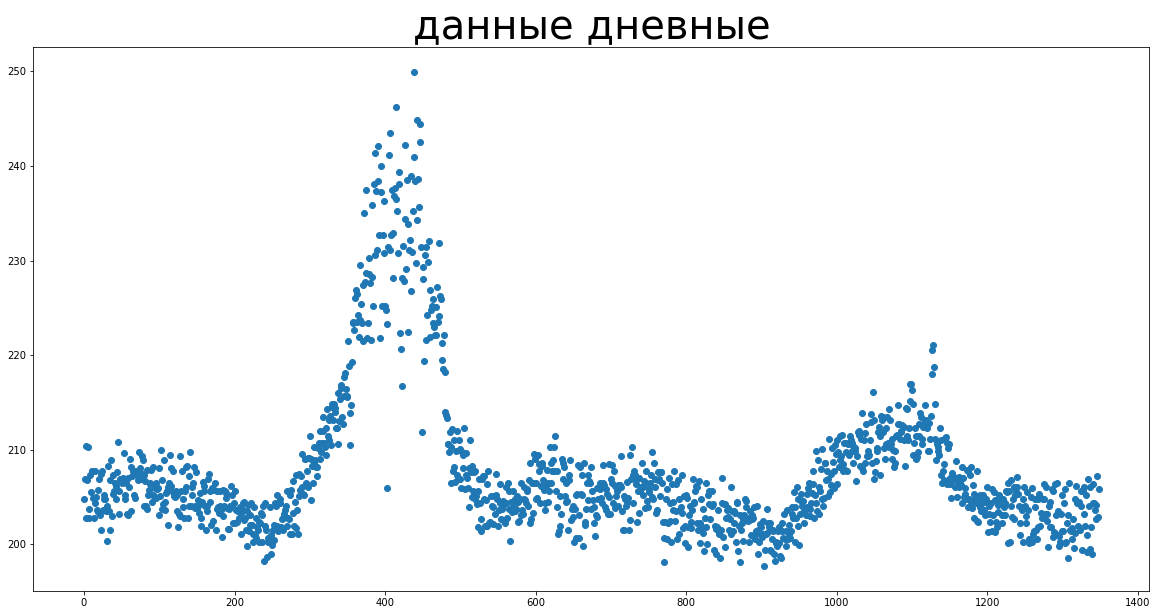

In [4]:
plt.figure(figsize=(20,10))
plt.title('данные дневные', fontsize=40)
plt.scatter(x=range(1349), y=vd_value[:1349]) 

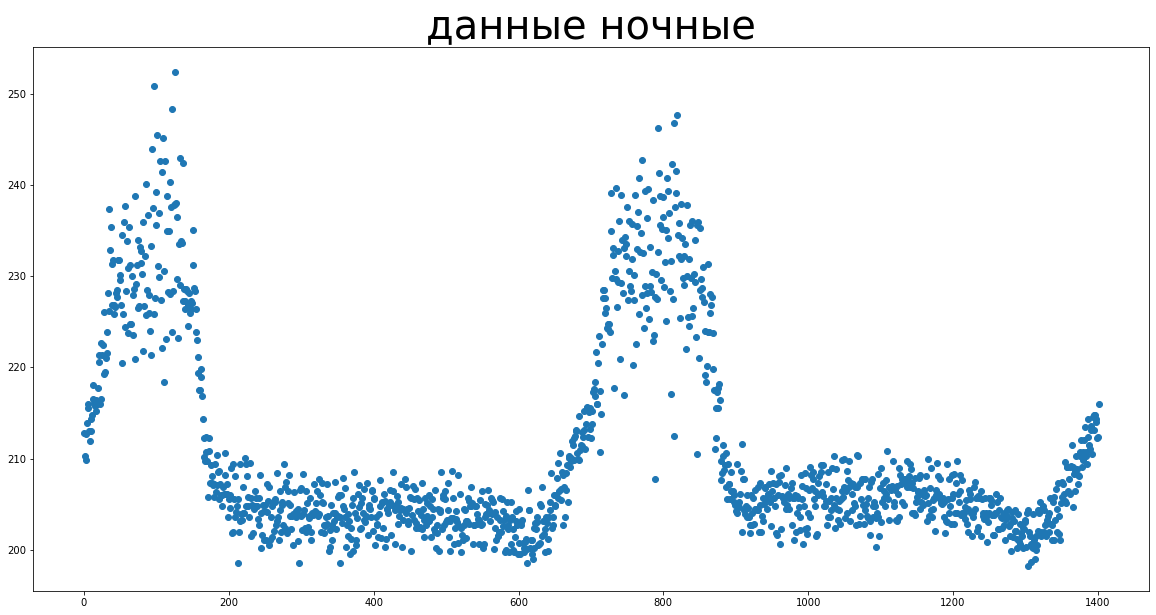

In [5]:
plt.figure(figsize=(20,10))
plt.title('данные ночные', fontsize=40)
plt.scatter(x=range(1402), y=vn_value[:1402]) 

# Основная обработка

In [6]:
v_d.isna().sum()

TimeValue    0
Value        0
dtype: int64

In [7]:
v_d[v_d['Value'] == 0].value_counts

<bound method DataFrame.value_counts of Empty DataFrame
Columns: [TimeValue, Value]
Index: []>

In [8]:
v_n.isna().sum()

TimeValue    0
Value        0
dtype: int64

In [9]:
v_n[v_n['Value'] == 0].value_counts

<bound method DataFrame.value_counts of Empty DataFrame
Columns: [TimeValue, Value]
Index: []>

In [10]:
mask = (s['Value|Ìàêñèìóì'] != 0)
s = s[mask]
s.shape

(818707, 2)

In [11]:
##########################################################################################
# Конвертируем TimeValue в тип Timestamp и делаем его индексным сталбцом исходной таблицы.
##########################################################################################

t1 = time.time()
v_d.index = pd.to_datetime(v_d.TimeValue, dayfirst=True)
print(time.time() - t1)

t1 = time.time()
v_n.index = pd.to_datetime(v_n.TimeValue, dayfirst=True)
print(time.time() - t1)

t1 = time.time()
s_10 = s.iloc[:200000]
s_10.index = pd.to_datetime(s_10.TimeValue, dayfirst=True)
s_10.rename(columns={'Value|Ìàêñèìóì': 'Value'}, inplace=True)
print(time.time() - t1)

0.21089768409729004
0.20390629768371582
26.08509373664856


In [12]:
s_samp = s.iloc[:1]
s_samp.index = pd.to_datetime(s_samp.TimeValue, dayfirst=True)
s_samp.rename(columns={'Value|Ìàêñèìóì': 'Value'}, inplace=True)

s_samp = s_samp.iloc[:1]     # "Откусываем" пример длинной xLen
s_samp = s_samp.Value.resample('s').interpolate()

s_samp # исполбзуется в create_samples

TimeValue
2019-03-01 00:00:09    194.281464
Freq: S, Name: Value, dtype: float64

In [13]:
########################################################
# Функция интерполяции всего массива значений по частям.
########################################################

def create_samples(data, xLen, step):
           
    data_len = data.iloc[:].shape[0]
    index = 0            
    count = 0
    
    
    batch_sum = s_samp   # берём шаблон для конкатинации Serias объектов
    
    while (index + xLen <= data_len):          # Идём по всей длине массива значений
        t1 = time.time()
        
        batch = data.iloc[index:index+xLen]     # "Откусываем" пример длинной xLen
      
        batch = batch.Value.resample('s').interpolate().resample('4T').interpolate().resample('1T').interpolate()
               
        batch = batch.dropna()
     
        now_shape = batch.shape[0]
     
        count += now_shape
        
        batch_sum = pd.concat([batch_sum, batch])
        
        index += step                          # Смещаеммся вперёд на step
        
        if index % step == 0:
            print(index, time.time()-t1)
            
    print(count)
    
    return batch_sum

In [14]:
batch_sum = create_samples(s_10, 1000, 1000)

1000 0.048999786376953125
2000 0.026988506317138672
3000 0.02598881721496582
4000 0.024963855743408203
5000 0.026984214782714844
6000 0.027985811233520508
7000 0.035985708236694336
8000 0.03497481346130371
9000 0.04097604751586914
10000 0.04397988319396973
11000 0.03397417068481445
12000 0.032987356185913086
13000 0.03397417068481445
14000 0.029984474182128906
15000 0.025985002517700195
16000 0.027986526489257812
17000 0.028983116149902344
18000 0.026983261108398438
19000 0.025983333587646484
20000 0.0259857177734375
21000 0.025984525680541992
22000 0.024985790252685547
23000 0.039977073669433594
24000 0.02698540687561035
25000 0.025984525680541992
26000 0.026984453201293945
27000 0.025989294052124023
28000 0.026981592178344727
29000 0.02498483657836914
30000 0.0259859561920166
31000 0.02998208999633789
32000 0.0319821834564209
33000 0.033219337463378906
34000 0.03797769546508789
35000 0.035982608795166016
36000 0.033974647521972656
37000 0.0339815616607666
38000 0.03796982765197754
39

In [75]:
# данные интерполируются поминутно по индексу
res_d = v_d.Value.resample('s').interpolate().resample('1T').asfreq().dropna()

res_n = v_n.Value.resample('s').interpolate().resample('1T').asfreq().dropna()

In [76]:
t1 = time.time()

s_10 = s.iloc[:105000]
s_10.index = pd.to_datetime(s_10.TimeValue, dayfirst=True)
s_10.rename(columns={'Value|Ìàêñèìóì': 'Value'}, inplace=True)

print(time.time() - t1)

12.719950675964355


In [77]:
batch_sum

TimeValue
2019-03-01 00:00:09    194.281464
2019-03-01 00:04:00    186.461330
2019-03-01 00:05:00    186.821789
2019-03-01 00:06:00    187.182248
2019-03-01 00:07:00    187.542708
                          ...    
2019-11-24 16:08:00    184.727026
2019-11-24 16:09:00    184.940660
2019-11-24 16:10:00    185.154295
2019-11-24 16:11:00    185.367930
2019-11-24 16:12:00    185.581564
Name: Value, Length: 386121, dtype: float64

In [79]:
res = batch_sum.to_frame()
res_v = batch_sum.values

Scaler = MinMaxScaler()
res_v = Scaler.fit_transform(res_v.reshape(-1,1))
res.Value = res_v
res_v = res_v.reshape(res_v.shape[0])

In [80]:
res_v

array([0.4564126 , 0.16430853, 0.17777271, ..., 0.11548711, 0.12346697,
       0.13144683])

In [81]:
buf1 = res_d
res_d = res_d.to_frame()

#Scaler_d = MinMaxScaler()

res_dv = buf1.values
res_dv = Scaler.transform(res_dv.reshape(-1,1))
res_d.Value = res_dv
res_dv = res_dv.reshape(res_dv.shape[0])

In [82]:
res_dv

array([0.86941623, 0.89343479, 0.91745334, ..., 0.7896772 , 0.83935542,
       0.88903363])

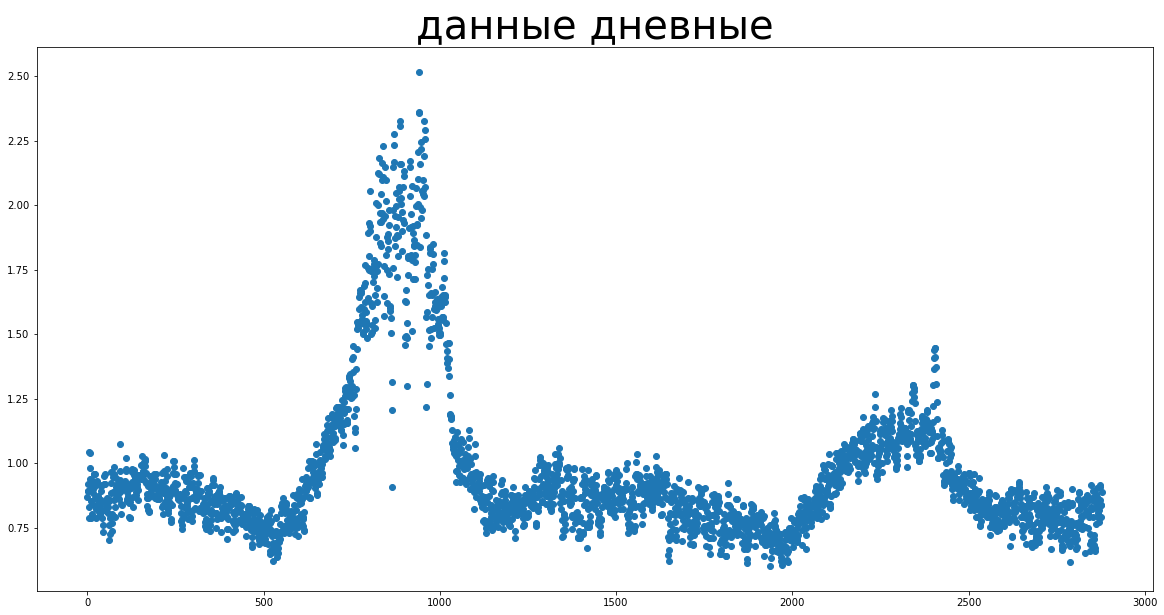

In [83]:
plt.figure(figsize=(20,10))
plt.title('данные дневные', fontsize=40)
plt.scatter(x=range(res_dv.shape[0]), y=res_dv) 

In [84]:
buf1 = res_n
res_n = res_n.to_frame()

#Scaler_n = MinMaxScaler()

res_nv = buf1.values
res_nv = Scaler.transform(res_nv.reshape(-1,1))
res_n.Value = res_nv
res_nv = res_nv.reshape(res_nv.shape[0])

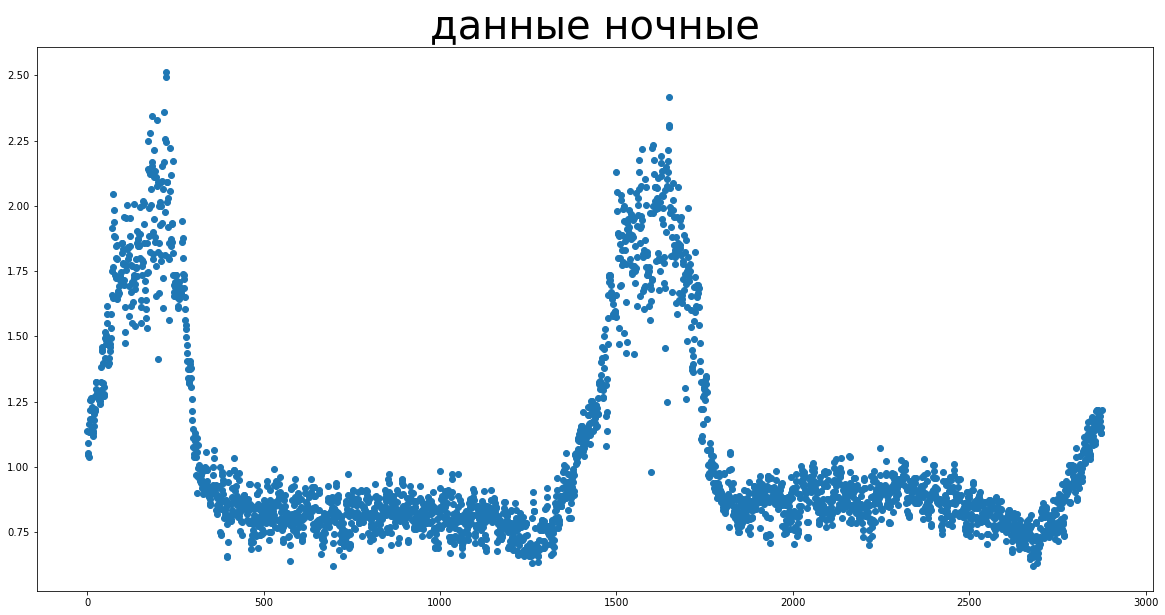

In [85]:
plt.figure(figsize=(20,10))
plt.title('данные ночные', fontsize=40)
plt.scatter(x=range(res_nv.shape[0]), y=res_nv) 

In [86]:
# создание обрабатываемого набора и именование
resedit_d = res_d
resedit_d.Value.name='Minus 0 minut'  # ЗАМЕНИЛ Minus 1440 minut

# создание обрабатываемого набора и именование
resedit_n = res_n
resedit_n.Value.name='Minus 0 minut'  # ЗАМЕНИЛ Minus 1440 minut


In [87]:
resedit_d.Value

TimeValue
2021-08-03 11:57:00    0.869416
2021-08-03 11:58:00    0.893435
2021-08-03 11:59:00    0.917453
2021-08-03 12:00:00    0.890408
2021-08-03 12:01:00    0.829320
                         ...   
2021-08-05 11:51:00    0.913488
2021-08-05 11:52:00    0.839185
2021-08-05 11:53:00    0.789677
2021-08-05 11:54:00    0.839355
2021-08-05 11:55:00    0.889034
Freq: T, Name: Minus 0 minut, Length: 2879, dtype: float64

In [88]:
###################################################
# создание и именование датафрейма скользящим окон.
###################################################

n=20 # шаг

allres=[] # лист из семплов

for i in range(0,73):
    res1=resedit_d.Value.shift(periods=-n*i)   # обращение к Series фрейма
    res1.name='Minus '+str(n*i)+' minut'     # ЗАМЕНИЛ (1440 - n*i) НА n*i
    allres.append(res1)

# [1,2,3,4,5] -> [2,3,4,5,Nan] -> [3,4,5,NaN,NaN]...  
    
for i in allres:
    resedit_d = pd.concat([resedit_d,i],axis=1)

#.....................................................................    
    
allres=[] # лист из семплов

for i in range(0,73):
    res1=resedit_n.Value.shift(periods=-n*i)   # обращение к Series фрейма
    res1.name='Minus '+str(n*i)+' minut'     # ЗАМЕНИЛ (1440 - n*i) НА n*i
    allres.append(res1)

# [1,2,3,4,5] -> [2,3,4,5,Nan] -> [3,4,5,NaN,NaN]...  
    
for i in allres:
    resedit_n=pd.concat([resedit_n,i],axis=1)    

In [89]:
resedit_d.drop('Value', axis=1, inplace=True)

resedit_n.drop('Value', axis=1, inplace=True)

In [90]:
resedit_n

,Minus 0 minut,Minus 20 minut,Minus 40 minut,Minus 60 minut,Minus 80 minut,Minus 100 minut,Minus 120 minut,Minus 140 minut,Minus 160 minut,Minus 180 minut,...,Minus 1260 minut,Minus 1280 minut,Minus 1300 minut,Minus 1320 minut,Minus 1340 minut,Minus 1360 minut,Minus 1380 minut,Minus 1400 minut,Minus 1420 minut,Minus 1440 minut
TimeValue,,,,,,,,,,,,,,,,,,,,,
2021-08-02 00:03:00,1.136933,1.204645,1.383646,1.393502,1.722489,1.836530,1.884236,1.859415,1.928669,2.064164,...,0.632513,0.684317,0.772643,0.699142,0.890178,0.914046,0.893570,1.158459,1.231424,1.198671
2021-08-02 00:04:00,1.093001,1.213020,1.448084,1.396680,1.801626,1.780987,1.951552,1.732185,2.009025,2.004966,...,0.664454,0.722344,0.844816,0.670057,0.869993,0.943121,0.968971,1.158775,1.197530,1.239296
2021-08-02 00:05:00,1.053265,1.221395,1.458936,1.415874,1.844744,1.778565,1.847550,1.903255,1.857426,2.168484,...,0.803882,0.758085,0.884027,0.693922,0.851727,0.974624,1.044372,1.140458,1.163635,1.211564
2021-08-02 00:06:00,1.045294,1.270689,1.444955,1.443076,1.851844,1.695810,1.671568,1.871533,1.713464,2.343723,...,0.905034,0.768681,0.920883,0.721066,0.850739,0.931680,1.048841,1.097776,1.126819,1.154537
2021-08-02 00:07:00,1.037322,1.326278,1.400221,1.460889,1.796712,1.957602,1.771820,1.848087,1.676401,2.153970,...,0.867802,0.779277,0.851710,0.762816,0.849750,0.835559,1.052107,1.060001,1.089738,1.155600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-03 23:55:00,1.144853,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-03 23:56:00,1.128825,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-03 23:57:00,1.129495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [91]:
# создание дамми-параметров по месяцу и часу
resedit_d.insert(0,'Month',(resedit_d.index + timedelta(minutes=1680)).month)
resedit_d.insert(0,'Hour',(resedit_d.index + timedelta(minutes=1680)).hour)
resedit_d=pd.get_dummies(resedit_d,columns=['Month'])
resedit_d=pd.get_dummies(resedit_d,columns=['Hour'])

# создание дамми-параметров по месяцу и часу
resedit_n.insert(0,'Month',(resedit_n.index + timedelta(minutes=1680)).month)
resedit_n.insert(0,'Hour',(resedit_n.index + timedelta(minutes=1680)).hour)
resedit_n=pd.get_dummies(resedit_n,columns=['Month'])
resedit_n=pd.get_dummies(resedit_n,columns=['Hour'])

In [92]:
# подгонка под шаблон датафрейма для подачи в сеть 

c1 = []

for i in range(0, 1441, 20):
    c1.append(f'Minus {i} minut')

for i in range(1, 13, 1):
    c1.append(f'Month_{i}')   

for i in range(24):
    c1.append(f'Hour_{i}')  
    
print(c1)


['Minus 0 minut', 'Minus 20 minut', 'Minus 40 minut', 'Minus 60 minut', 'Minus 80 minut', 'Minus 100 minut', 'Minus 120 minut', 'Minus 140 minut', 'Minus 160 minut', 'Minus 180 minut', 'Minus 200 minut', 'Minus 220 minut', 'Minus 240 minut', 'Minus 260 minut', 'Minus 280 minut', 'Minus 300 minut', 'Minus 320 minut', 'Minus 340 minut', 'Minus 360 minut', 'Minus 380 minut', 'Minus 400 minut', 'Minus 420 minut', 'Minus 440 minut', 'Minus 460 minut', 'Minus 480 minut', 'Minus 500 minut', 'Minus 520 minut', 'Minus 540 minut', 'Minus 560 minut', 'Minus 580 minut', 'Minus 600 minut', 'Minus 620 minut', 'Minus 640 minut', 'Minus 660 minut', 'Minus 680 minut', 'Minus 700 minut', 'Minus 720 minut', 'Minus 740 minut', 'Minus 760 minut', 'Minus 780 minut', 'Minus 800 minut', 'Minus 820 minut', 'Minus 840 minut', 'Minus 860 minut', 'Minus 880 minut', 'Minus 900 minut', 'Minus 920 minut', 'Minus 940 minut', 'Minus 960 minut', 'Minus 980 minut', 'Minus 1000 minut', 'Minus 1020 minut', 'Minus 1040 min

In [93]:
df_ = pd.DataFrame(columns=c1)

In [94]:
df_

,Minus 0 minut,Minus 20 minut,Minus 40 minut,Minus 60 minut,Minus 80 minut,Minus 100 minut,Minus 120 minut,Minus 140 minut,Minus 160 minut,Minus 180 minut,...,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23


In [95]:

df_ = pd.DataFrame(columns=c1)
frames = [df_, resedit_d]
resedit_d = pd.concat(frames, sort=False)

#....................................................

df_ = pd.DataFrame(columns=c1)
frames = [df_, resedit_n]
resedit_n = pd.concat(frames, sort=False)


In [96]:
res_d = res_d.Value

res_n = res_n.Value

In [97]:
# создание колонки прогноза на 4 часа
dfprog=res_d.shift(periods=-1680)
dfprog.name='Prognoz 4 hour'
dfopor_d=pd.concat([resedit_d,dfprog], axis=1)

# создание колонки прогноза на 4 часа
dfprog=res_n.shift(periods=-1680)
dfprog.name='Prognoz 4 hour'
dfopor_n=pd.concat([resedit_n,dfprog], axis=1)

In [98]:
# создание колонок меток времени для старта и прогноза
dfopor_d['Data_Time_Start'] = dfopor_d.index + timedelta(minutes=1440)
dfopor_d['Data_Time_Prognoz'] = dfopor_d.index + timedelta(minutes=1680)

# создание колонок меток времени для старта и прогноза
dfopor_n['Data_Time_Start'] = dfopor_n.index + timedelta(minutes=1440)
dfopor_n['Data_Time_Prognoz'] = dfopor_n.index + timedelta(minutes=1680)

In [99]:
# сброс строк без целевой переменной
Test_sub_d=dfopor_d.dropna(subset=['Prognoz 4 hour'],axis=0)

# сброс строк без целевой переменной
Test_sub_n=dfopor_n.dropna(subset=['Prognoz 4 hour'],axis=0)

In [100]:
# набор для обучения (109 входов и целевая переменная)
X_test_sub_d=Test_sub_d.iloc[:,:110]

# набор для обучения (109 входов и целевая переменная)
X_test_sub_n=Test_sub_n.iloc[:,:110]

In [101]:
# заполнение пустых дамми-значений
X_test_sub_d=X_test_sub_d.fillna(0)

# заполнение пустых дамми-значений
X_test_sub_n=X_test_sub_n.fillna(0)

In [102]:
# массивы входов и целевой переменной для подачи в сеть
X_d=X_test_sub_d.values[:,:109]
y_d=X_test_sub_d.values[:,109]

# массивы входов и целевой переменной для подачи в сеть
X_n=X_test_sub_n.values[:,:109]
y_n=X_test_sub_n.values[:,109]

## Modelling

In [103]:
# модель нейросети
X_d = np.asarray(X_d).astype(np.float32)
y_d = np.asarray(y_d).astype(np.float32)

# модель нейросети
X_n = np.asarray(X_n).astype(np.float32)
y_n = np.asarray(y_n).astype(np.float32)



In [104]:
input_shape_conv = (109, 1)

def conv_model():

    modelC = Sequential()

    modelC.add(Conv1D(64, 5, input_shape = input_shape_conv, activation="relu"))
    modelC.add(Conv1D(64, 5, activation="relu"))
    modelC.add(MaxPooling1D())
    modelC.add(Flatten())
    modelC.add(Dense(100, activation="relu"))
    modelC.add(Dense(1, activation="linear"))

    # компиляция модели

    modelC.compile(loss='mean_absolute_error', optimizer=optimizers.Adam(learning_rate=0.0001), metrics=['log_cosh'])

    modelC.summary()
    
    return modelC



In [105]:
######################################
#  Функция получения метрик и ошибки.
######################################

def show_losses(history):

    # графики обучения
    acc = history.history['log_cosh']
    val_acc = history.history['val_log_cosh']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()
    


In [106]:
################################
# Функция визуализации графиков.
################################

def showPredict(start, step, channel, predVal, yValUnscaled):
    '''
        start - точка с которой начинаем отрисовку графика
        step - длина графика, которую отрисовываем
        channel - какой канал отрисовываем  
  
    '''
    
    plt.figure(figsize=(22,6))
    plt.plot(predVal[start:start+step],#, 0],
             label='Прогноз')
    plt.plot(yValUnscaled[start:start+step],#, channel], 
             label='Базовый ряд')
    plt.xlabel('Время')
    plt.ylabel('Значение')
    plt.legend()
    plt.show()

In [107]:
############################################
# Расчет линейнного коэффициента корреляции.
############################################

def correlate(a, b):

  ma = a.mean() 
  mb = b.mean() 
  mab = (a*b).mean() 
  sa = a.std() 
  sb = b.std() 
  
  val = 1
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val

In [108]:
#####################################################################################
# Расчитываем корелляцию между базовым рядом и предсказанным  с разныс сдвигом шагов.
#####################################################################################


def showCorr(channels, corrSteps, predVal, yValUnscaled):

    '''
        channels - по каким каналам отображать корреляцию
        corrSteps - на какое количество шагов смещать сигнал назад для рассчёта корреляции

    '''        
  # Проходим по всем каналам
    for ch in channels:
      corr = [] 
      yLen = yValUnscaled.shape[0] 

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
      for i in range(corrSteps):
        corr.append(correlate(yValUnscaled[:yLen-i], predVal[i:]))   
        own_corr = [] 

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
      for i in range(corrSteps):
        own_corr.append(correlate(yValUnscaled[:yLen-i], yValUnscaled[i:]))  

    # Отображаем график коррелций для данного шага
      plt.figure(figsize=(14,7))
      plt.plot(corr, label='Предсказание на ' + str(ch+1) + ' шаг')
      plt.plot(own_corr, label='Эталон')

    plt.xlabel('Время')
    plt.ylabel('Значение')
    plt.legend()
    plt.show()

In [109]:
############################################
# Функция отображения необходимых графиков.
############################################


def get_inf(model, window, steps, X, y, Scaler):
    
    '''
    model - текущая модель
    window - кол-во значений на графике предсказанного временного ряда
    steps - кол-во сдвигов подсчета автокорелляции
    
    '''
#    show_losses(history)
    
    predictions = model.predict(X, verbose=1)
    pred = Scaler.inverse_transform(predictions)
    y_un = Scaler.inverse_transform(y.reshape(-1,1))
    
    showPredict(0,window,0,pred,y_un)
    
    pred = predictions.reshape(predictions.shape[0])
    showCorr([0], steps, pred, y)
    

In [110]:
############
# Callbacks.
############

def create_call(name_model):
    
    checkpoint = ModelCheckpoint(path + name_model, verbose=1, monitor='val_log_cosh', save_best_only=True, mode='auto')
    earlystop = EarlyStopping(monitor='val_log_cosh', patience=10, restore_best_weights=True)
    callbacks_list = [checkpoint, earlystop]
    
    return callbacks_list

# Дневные

In [51]:
callbacks_list = create_call('model_Day')

In [52]:
model_Day = conv_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 105, 64)           384       
                                                                 
 conv1d_1 (Conv1D)           (None, 101, 64)           20544     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 50, 64)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 3200)              0         
                                                                 
 dense (Dense)               (None, 100)               320100    
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                        

In [53]:
model_Day.load_weights(path + 'model_final_C.hdf5')

38/38 [==============================] - 0s 5ms/step


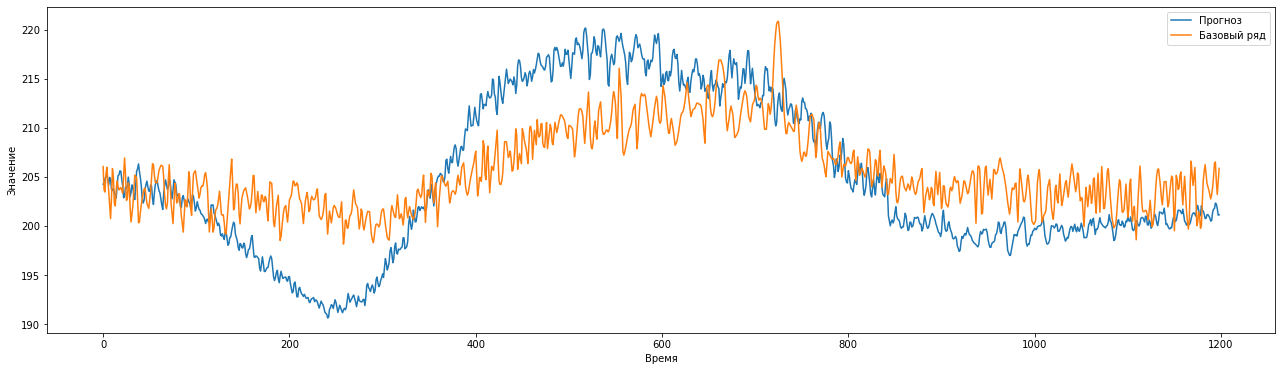

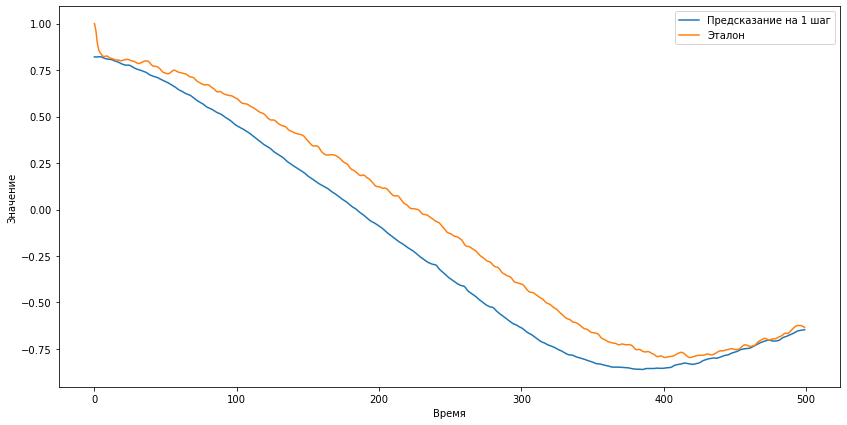

In [111]:
get_inf(model_Day, 3000, 500, X_d, y_d, Scaler)

In [112]:
y_d

array([0.89595175, 0.8068379 , 0.7989162 , ..., 0.7896772 , 0.8393554 ,
       0.8890336 ], dtype=float32)

## Ночные

In [114]:
callbacks_list = create_call('model_Night')

In [115]:
model_Night = conv_model()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 105, 64)           384       
                                                                 
 conv1d_5 (Conv1D)           (None, 101, 64)           20544     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 50, 64)           0         
 1D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 3200)              0         
                                                                 
 dense_4 (Dense)             (None, 100)               320100    
                                                                 
 dense_5 (Dense)             (None, 1)                 101       
                                                      

In [116]:
model_Night.load_weights(path + 'model_final_C.hdf5')

38/38 [==============================] - 0s 4ms/step


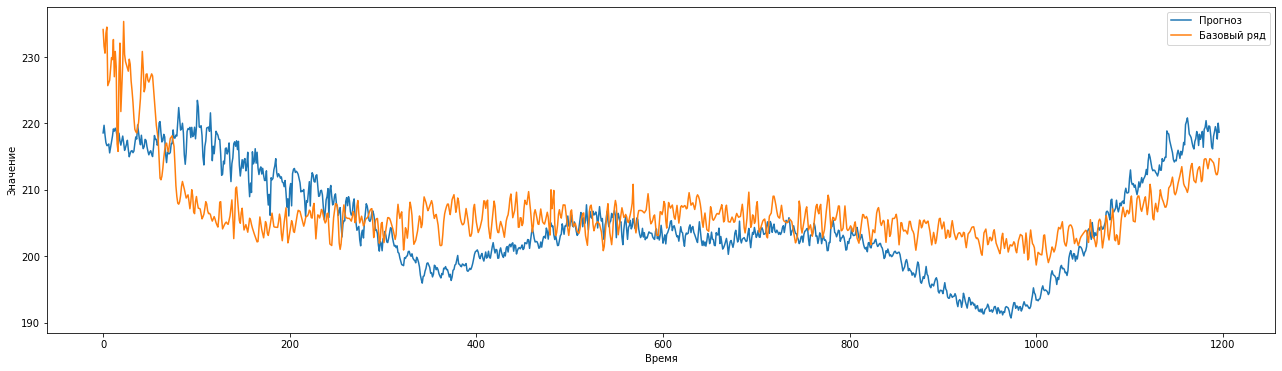

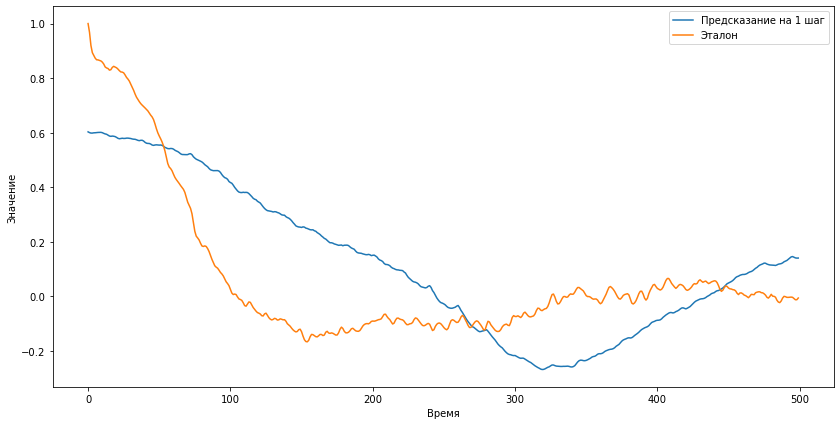

In [117]:
get_inf(model_Night, 3000, 500, X_n, y_n, Scaler)

## Сохранение результатов

In [118]:
predictions = model_Day.predict(X_d, verbose=1) 
predictions = Scaler.inverse_transform(predictions)

38/38 [==============================] - 0s 5ms/step


In [119]:
predictions

array([[204.24515],
       [204.49748],
       [204.81665],
       ...,
       [201.7704 ],
       [201.09744],
       [201.13144]], dtype=float32)

In [120]:
# получаем выходной набор в виде датафрейма с полями метки времени и значений
submission = pd.DataFrame({'TimeValue':Test_sub_d['Data_Time_Prognoz'].values, 'Value':predictions[:,0]}, columns=['TimeValue', 'Value'])
submission.to_csv(path + 'Прогноз_Day.csv')

In [121]:
predictions = model_Night.predict(X_n, verbose=1) 
predictions = Scaler.inverse_transform(predictions)

38/38 [==============================] - 0s 5ms/step


In [124]:
predictions

array([[218.56732],
       [219.71637],
       [218.26048],
       ...,
       [217.64215],
       [220.03194],
       [218.67728]], dtype=float32)

In [126]:
# получаем выходной набор в виде датафрейма с полями метки времени и значений
submission = pd.DataFrame({'TimeValue':Test_sub_n['Data_Time_Prognoz'].values, 'Value':predictions[:,0]}, columns=['TimeValue', 'Value'])
submission.to_csv(path + 'Прогноз_Night.csv')